In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import math
import skimage.transform

In [2]:
# ./psfex-rec ~/Downloads/sim08/sim08.psf /tmp/test.fits 1545.4493408203125 2138.5537109375
esheldon = fits.open('/tmp/test.fits')[0].data
esheldon /= esheldon.sum()

In [3]:
# ./psfForMasking ~/Downloads/sim08/sim08.psf 1545.4493408203125 2138.5537109375 /tmp/martin.fits
martin = fits.open('/tmp/martin.fits')[0].data
martin /= martin.sum()

In [4]:
psf_fits = fits.open('/home/aalvarez/Downloads/sim08/sim08.psf')
psf_data = psf_fits['PSF_DATA']

In [5]:
psf_data.header

XTENSION= 'BINTABLE'           / THIS IS A BINARY TABLE (FROM THE LDACTOOLS)    
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                81000 / BYTES PER ROW                                  
NAXIS2  =                    1 / NUMBER OF ROWS                                 
PCOUNT  =                    0 / RANDOM PARAMETER COUNT                         
GCOUNT  =                    1 / GROUP COUNT                                    
TFIELDS =                    1 / FIELDS PER ROWS                                
EXTNAME = 'PSF_DATA'           / TABLE NAME                                     
LOADED  =                10454 / Number of loaded sources                       
ACCEPTED=                 8926 / Number of accepted sources                     
CHI2    =           1.57796242 / Final reduced chi2                             
POLNAXIS=                   

In [6]:
psf = psf_data.data[0][0] # First row, first column
n_components = psf.shape[0]

In [7]:
abs_min, abs_max = psf.min(), psf.max()

<IPython.core.display.Javascript object>


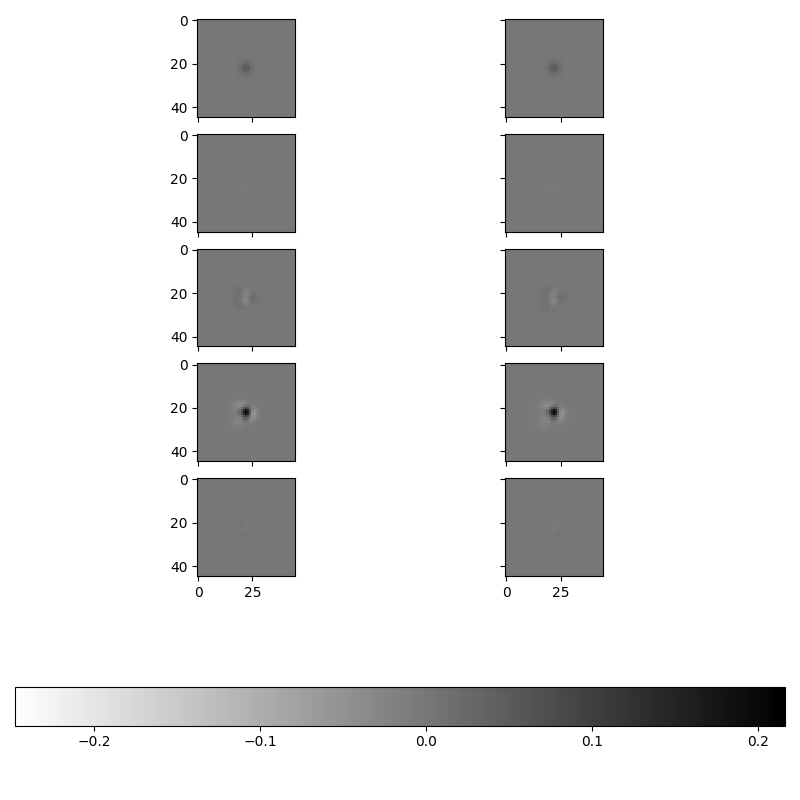

In [8]:
cmap = plt.get_cmap('binary')
norm = colors.Normalize(abs_min, abs_max)

ncols = 2
nrows = int(n_components/2)

fig, axs = plt.subplots(nrows, ncols, figsize=(8,8))
for i in range(int(nrows)):
    for j in range(ncols):
        im = axs[i, j].imshow(psf[i], cmap)
        im.set_norm(norm)
        axs[i, j].label_outer()
plt.tight_layout()
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=.1)

In [9]:
catalog = Table.read('/home/aalvarez/Downloads/sim08/sex.out.fits', hdu='LDAC_OBJECTS')
img = fits.open('/home/aalvarez/Downloads/sim08/sim08.fits')

<IPython.core.display.Javascript object>


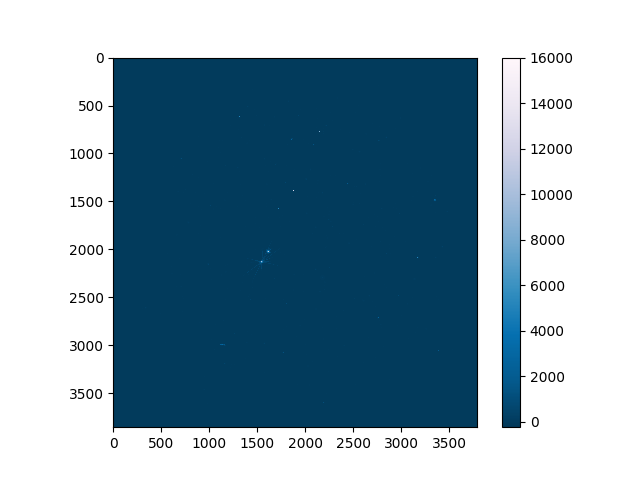

In [10]:
plt.figure()
plt.imshow(img[0].data, cmap='PuBu_r')
plt.colorbar()

In [11]:
catalog['FLUX_RADIUS'].argmax()

492

In [12]:
def get_entry_image(full, catalog, index, size=24):
    w, h = full.shape
    center_x = int(catalog[index]['X_IMAGE'])
    center_y = int(catalog[index]['Y_IMAGE'])
    hs = int(size/2)
    return full[(center_y-hs):(center_y+hs), (center_x-hs):(center_x+hs)]

<IPython.core.display.Javascript object>


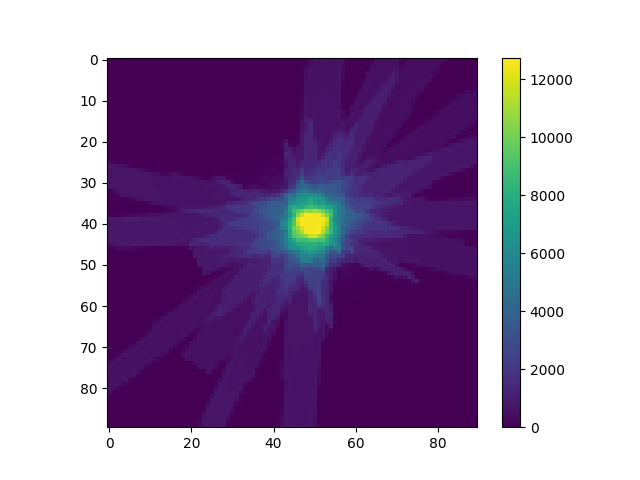

In [13]:
plt.figure()
plt.imshow(get_entry_image(img[0].data, catalog, 492, 90))
plt.colorbar()

<IPython.core.display.Javascript object>


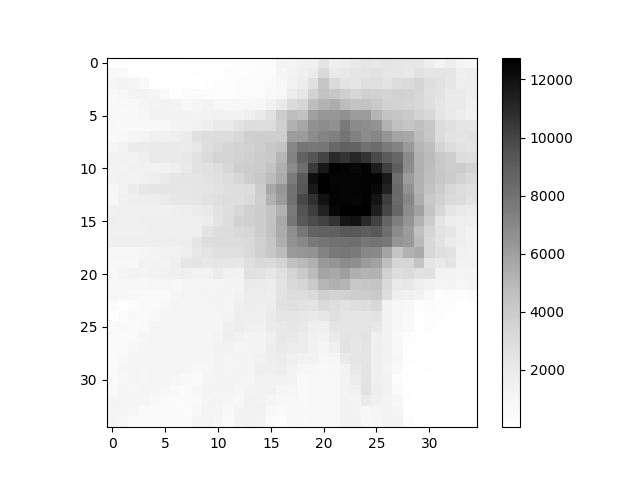

In [14]:
vignet = catalog[492]['VIGNET']
plt.figure()
plt.imshow(vignet, cmap=plt.get_cmap('Greys'))
plt.colorbar()

In [15]:
def get_relative(headers, x, y):
    rx = (x - headers['POLZERO1']) / headers['POLSCAL1']
    ry = (y - headers['POLZERO2']) / headers['POLSCAL2']
    return rx, ry

def get_psf(x, y):
    result = np.array(psf[0], copy=True, dtype=np.float64)
    rx, ry = get_relative(psf_data.header, x, y)
    for order in range(1, 3 + 1):
        for order_y in range(order + 1):
            order_x = order - order_y
            i_coef = int(order_x + order_y * (3 + 1) - (order_y * (order_y - 1)) / 2)
            nf = (rx ** order_x) * (ry ** order_y)
    
            for cy in range(45):
                for cx in range(45):
                    result[cx, cy] += nf * psf[i_coef, cx, cy]
    return result

<IPython.core.display.Javascript object>


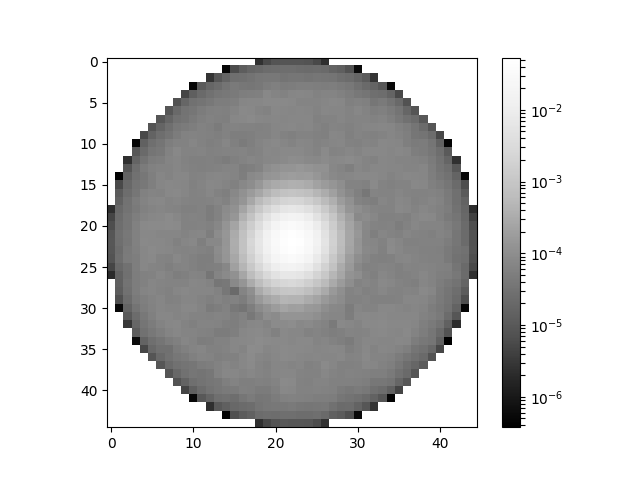

1545.4493408203125 2138.5537109375


In [16]:
plt.figure()
print(f"{catalog[492]['X_IMAGE']}", f"{catalog[492]['Y_IMAGE']}")
subpsf = get_psf(catalog[492]['X_IMAGE'], catalog[492]['Y_IMAGE'])
vmin = subpsf[subpsf != 0].min()
plt.imshow(
    subpsf,
    cmap=plt.get_cmap('Greys_r'),
    norm=colors.LogNorm(vmin=vmin, vmax=subpsf.max())
)
plt.colorbar()

In [17]:
def lanczos_kernel(x, a):
    if x == 0: 
        return 1.
    elif abs(x) > a:
        return 0.
    return a * math.sin(math.pi * x) * math.sin(math.pi * x / a) / (math.pi * x) ** 2

<IPython.core.display.Javascript object>


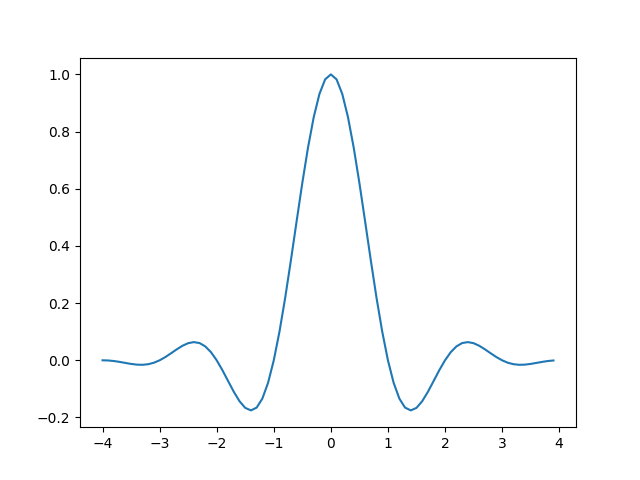

In [18]:
plt.figure()
xs = np.arange(-4, 4, step=0.1)
plt.plot(xs, list(map(lambda x: lanczos_kernel(x, 4), xs)))

In [19]:
recon_size = math.ceil(psf_data.header['PSF_SAMP'] * psf_data.header['PSFAXIS1'])
if recon_size % 2 == 0:
    recon_size += 1
print(recon_size)

39


In [20]:
def centroid(original):
    f = 0.
    fx = 0.
    fy = 0.
    for x in range(original.shape[0]):
        for y in range(original.shape[1]):
            f += original[x, y]
            fx += x * original[x, y]
            fy += y * original[x, y]
    return fx / f, fy / f
    
def lanczos_resample(original, ox_center, oy_center, x_offset, y_offset, order):  
    v = 0.
    x_pos = ox_center + x_offset
    y_pos = oy_center + y_offset
    
    nx = math.floor(x_pos+0.5)
    ny = math.floor(y_pos+0.5)
    
    if nx < 0 or ny < 0 or nx > original.shape[0] -1 or ny > original.shape[1] -1:
        return 0.
    
    for y in range(int(ny - order), int(ny + order + 1)):
        for x in range(int(nx - order), int(nx + order + 1)):
            if x < 0 or y < 0 or x > original.shape[0] - 1 or y > original.shape[1] - 1:
                continue
            dx = x_pos - x
            dy = y_pos - y
            v += lanczos_kernel(dx, order) * lanczos_kernel(dy, order) * original[x, y]
    return v
      
def resize(original, size, pixel_sample=None, order=4):
    if pixel_sample is None:
        pixel_sample = size / original.shape[0]
    resized = np.zeros((size, size), dtype=np.float64)
    rx_center = math.floor(size/2)
    if rx_center % 2 == 0:
        rx_center += 1
    ry_center = rx_center
    ox_center, oy_center = centroid(original)
    for rx in range(size):
        for ry in range(size):
            x_offset = (rx - rx_center) / pixel_sample
            y_offset = (ry - ry_center) / pixel_sample
            resized[rx,ry] = lanczos_resample(original, ox_center, oy_center, x_offset, y_offset, order)
    return resized

In [21]:
centroid(subpsf)

(22.01841586707577, 21.971544484872748)

In [22]:
my_resized = resize(subpsf, 39, psf_data.header['PSF_SAMP'])
my_resized /= my_resized.sum()

<IPython.core.display.Javascript object>


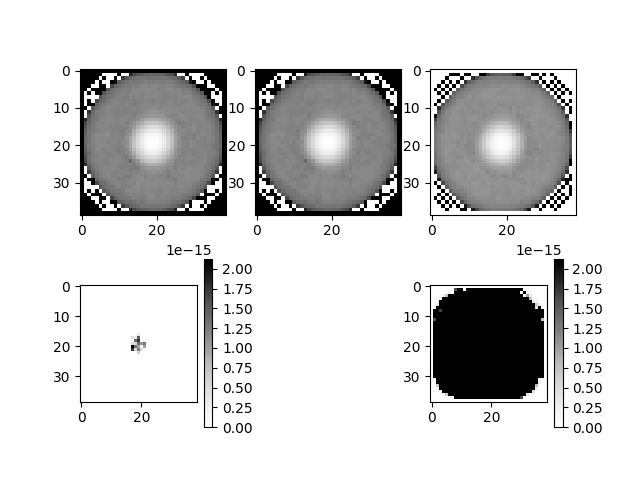

In [23]:
img_norm = colors.LogNorm(
    vmin=vmin,
    vmax=max(my_resized.max(), martin.max(), esheldon.max()),
    clip=True
)
err_norm = colors.Normalize()#vmin=-0.028, vmax=0.028)
cmap = plt.get_cmap('Greys_r')
err_cmap = plt.get_cmap('Greys')

plt.figure()

plt.subplot(2, 3, 1)
plt.imshow(
    my_resized,
    norm=img_norm,
    cmap = cmap
)

plt.subplot(2, 3, 2)
plt.imshow(
    martin,
    norm=img_norm,
    cmap = cmap
)

plt.subplot(2, 3, 3)
plt.imshow(
    esheldon,
    norm=img_norm,
    cmap = cmap
)

plt.subplot(2, 3, 4)
plt.imshow(
    (my_resized - martin) ** 2,
    norm=err_norm,
    cmap = err_cmap
)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(
    (esheldon - martin) ** 2,
    norm=err_norm,
    cmap = err_cmap
)

plt.colorbar()

In [24]:
def plot_vignet_vs_psf(axs, row, catalog, index):
    subpsf = get_psf(catalog[index]['X_IMAGE'], catalog[index]['Y_IMAGE'])
    subpsf /= subpsf.sum()
    subpsf += abs(subpsf.min())
    subpsf[subpsf==0] = subpsf[subpsf>0].min()
    
    im = axs[row, 0].imshow(
        subpsf,
        cmap=plt.get_cmap('Greys_r'),
        norm=colors.LogNorm(vmin=subpsf.min(), vmax=subpsf.max())
    )
    axs[row, 0].set_title(index)
    
    vignet = np.array(catalog[index]['VIGNET'], copy=True)
    vignet[vignet<=0]=vignet[vignet>0].min()
    axs[row,1].imshow(
        vignet,
        cmap=plt.get_cmap('Greys_r'),
        norm=colors.LogNorm(vmin=vignet.min(), vmax=vignet.max())
    )

<IPython.core.display.Javascript object>


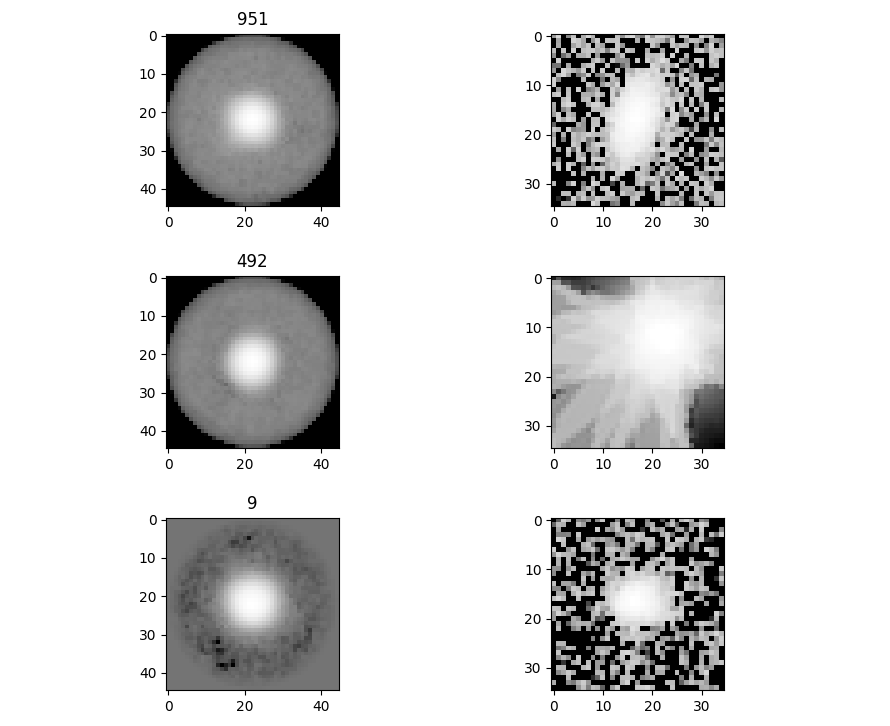

<IPython.core.display.Javascript object>


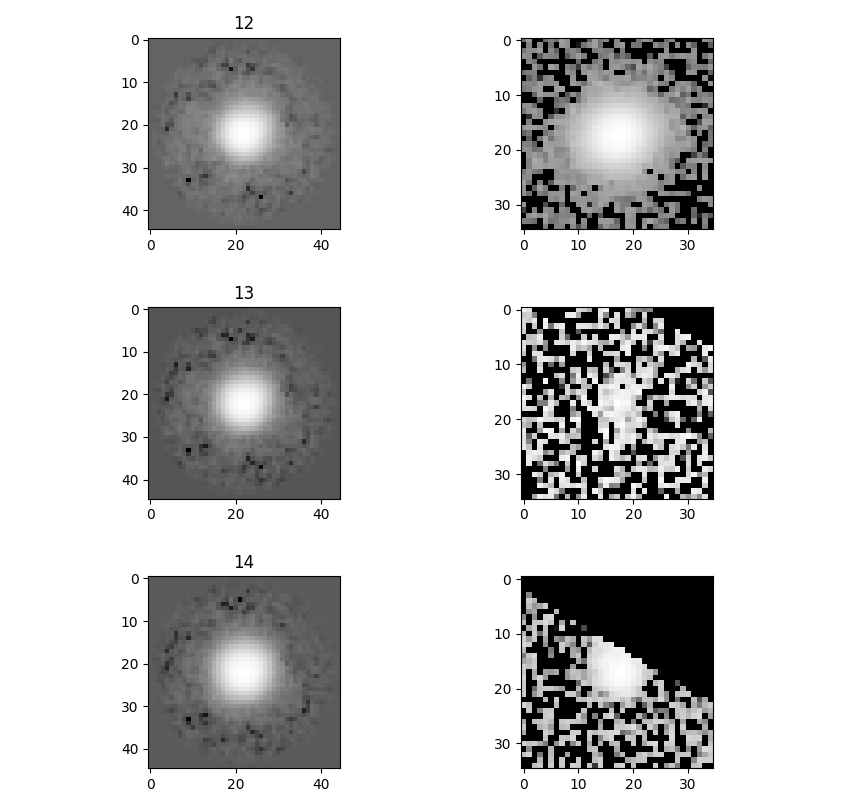

<IPython.core.display.Javascript object>


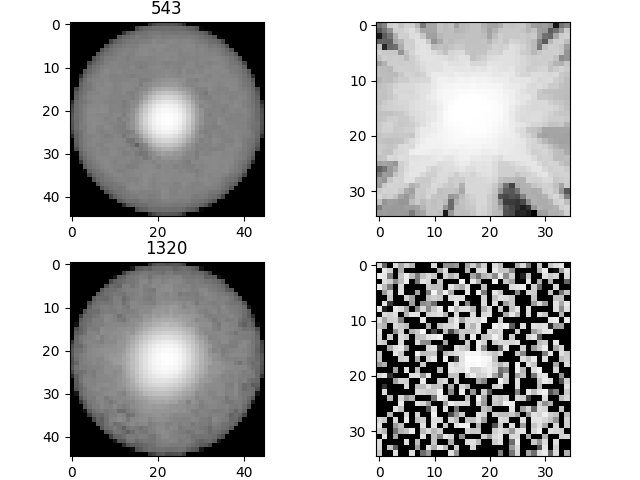

In [25]:
fig, axs = plt.subplots(3, 2)
plot_vignet_vs_psf(axs, 0, catalog, 951)
plot_vignet_vs_psf(axs, 1, catalog, 492)
plot_vignet_vs_psf(axs, 2, catalog, 9)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

fig2, axs2 = plt.subplots(3, 2)
plot_vignet_vs_psf(axs2, 0, catalog, 12)
plot_vignet_vs_psf(axs2, 1, catalog, 13)
plot_vignet_vs_psf(axs2, 2, catalog, 14)
fig2.tight_layout(pad=0, w_pad=0, h_pad=0)

fig3, axs3 = plt.subplots(2, 2)
plot_vignet_vs_psf(axs3, 0, catalog, 543)
plot_vignet_vs_psf(axs3, 1, catalog, 1320)
fig3.tight_layout(pad=0, w_pad=0, h_pad=0)
